In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim
import branca.colormap as cm
from geopy.exc import GeocoderTimedOut
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import rando

In [14]:
def setup_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Run in headless mode (optional)
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("start-maximized")
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36")
    service = Service()  # Automatically locate ChromeDriver
    driver = webdriver.Chrome(service=service, options=options)
    return driver

def scrape_page(driver):
    properties = []
    try:
        # Wait for property cards to load
        WebDriverWait(driver, 30).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "article[data-test='property-card']"))
        )
        property_cards = driver.find_elements(By.CSS_SELECTOR, "article[data-test='property-card']")

        for card in property_cards:
            try:
                price = card.find_element(By.CSS_SELECTOR, "span[data-test='property-card-price']").text.strip()
                address = card.find_element(By.CSS_SELECTOR, "address").text.strip()

                # Extract details (beds, baths, sqft)
                details = card.find_elements(By.CSS_SELECTOR, "ul li")
                beds = details[0].text if len(details) > 0 else "N/A"
                baths = details[1].text if len(details) > 1 else "N/A"
                sqft = details[2].text if len(details) > 2 else "N/A"

                properties.append({
                    "Price": price,
                    "Address": address,
                    "Beds": beds,
                    "Baths": baths,
                    "Sqft": sqft
                })
            except Exception as e:
                print(f"Error extracting data for a property: {e}")
    except Exception as e:
        print(f"Error scraping page: {e}")
    return properties

def scrape_zillow_condos():
    base_url = "https://www.zillow.com/cleveland-oh/condos/"
    driver = setup_driver()
    driver.get(base_url)

    all_properties = []
    page = 1

    while True:
        print(f"Scraping page {page}...")
        properties = scrape_page(driver)
        if not properties:
            break
        all_properties.extend(properties)

        try:
            # Debugging: Check current page HTML
            print(driver.page_source[:500])

            # Navigate to the next page
            next_button = driver.find_element(By.CSS_SELECTOR, "a[title='Next page']")
            next_button.click()
            time.sleep(random.uniform(2, 4))
        except Exception as e:
            print("No more pages or error navigating to next page:", e)
            break

        page += 1

    driver.quit()
    return all_properties

if __name__ == "__main__":
    scraped_data = scrape_zillow_condos()
    df = pd.DataFrame(scraped_data)
    df.to_csv("zillow_cleveland_condos.csv", index=False)
    print("Scraping complete. Data saved to zillow_cleveland_condos.csv")


Scraping page 1...
<html lang="en"><head><style>.LGLeeN-keyboard-shortcuts-view{display:-webkit-box;display:-webkit-flex;display:-moz-box;display:-ms-flexbox;display:flex}.LGLeeN-keyboard-shortcuts-view table,.LGLeeN-keyboard-shortcuts-view tbody,.LGLeeN-keyboard-shortcuts-view td,.LGLeeN-keyboard-shortcuts-view tr{background:inherit;border:none;margin:0;padding:0}.LGLeeN-keyboard-shortcuts-view table{display:table}.LGLeeN-keyboard-shortcuts-view tr{display:table-row}.LGLeeN-keyboard-shortcuts-view td{-moz-box-siz
Scraping page 2...
<html lang="en"><head><style>.LGLeeN-keyboard-shortcuts-view{display:-webkit-box;display:-webkit-flex;display:-moz-box;display:-ms-flexbox;display:flex}.LGLeeN-keyboard-shortcuts-view table,.LGLeeN-keyboard-shortcuts-view tbody,.LGLeeN-keyboard-shortcuts-view td,.LGLeeN-keyboard-shortcuts-view tr{background:inherit;border:none;margin:0;padding:0}.LGLeeN-keyboard-shortcuts-view table{display:table}.LGLeeN-keyboard-shortcuts-view tr{display:table-row}.LGLeeN-

In [16]:
df.head()

,Price,Address,Beds,Baths,Sqft
0,"$99,900","1383 East Blvd, Cleveland, OH 44106",2 bds,2 ba,"2,000 sqft"
1,"$149,900","750 Prospect Ave E APT 502, Cleveland, OH 44115",1 bd,1 ba,742 sqft
2,"$205,000","2043 Random Rd, Cleveland, OH 44106",2 bds,1 ba,-- sqft
3,"$219,900","1951 W 26th St APT 414, Cleveland, OH 44113",1 bd,2 ba,"1,260 sqft"
4,"$199,000","8205 Franklin Blvd APT 14, Cleveland, OH 44102",2 bds,2 ba,"1,818 sqft"


In [20]:
# Clean the 'Beds' column
df['Beds'] = df['Beds'].str.extract(r'(\d+)').astype(float)  # Extract numeric values

# Clean the 'Baths' column
df['Baths'] = df['Baths'].str.extract(r'(\d+)').astype(float)

# Clean the 'Sqft' column
df['Sqft'] = df['Sqft'].str.replace(',', '')  # Remove commas
df['Sqft'] = df['Sqft'].str.extract(r'(\d+)').astype(float)  # Extract numeric values

In [28]:
df.head()

,Price,Address,Beds,Baths,Sqft
0,"$99,900","1383 East Blvd, Cleveland, OH 44106",2.0,2.0,2000.0
1,"$149,900","750 Prospect Ave E APT 502, Cleveland, OH 44115",1.0,1.0,742.0
2,"$205,000","2043 Random Rd, Cleveland, OH 44106",2.0,1.0,NaN
3,"$219,900","1951 W 26th St APT 414, Cleveland, OH 44113",1.0,2.0,1260.0
4,"$199,000","8205 Franklin Blvd APT 14, Cleveland, OH 44102",2.0,2.0,1818.0


In [34]:
df_cleaned = df.dropna(subset=['Sqft'])

In [36]:
df.head()

,Price,Address,Beds,Baths,Sqft
0,"$99,900","1383 East Blvd, Cleveland, OH 44106",2.0,2.0,2000.0
1,"$149,900","750 Prospect Ave E APT 502, Cleveland, OH 44115",1.0,1.0,742.0
2,"$205,000","2043 Random Rd, Cleveland, OH 44106",2.0,1.0,NaN
3,"$219,900","1951 W 26th St APT 414, Cleveland, OH 44113",1.0,2.0,1260.0
4,"$199,000","8205 Franklin Blvd APT 14, Cleveland, OH 44102",2.0,2.0,1818.0


In [78]:
df = df.dropna(subset=['Sqft'])

[2000.  742.   nan 1260. 1818. 1000. 2044. 4378. 1456. 2890. 2141. 1800.
  696.  936. 1574. 1885.]
0


In [44]:
df.shape[0]

26

In [46]:
df.shape[1]

5

In [48]:
# Convert numerical columns to proper types
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)
df['Sqft'] = df['Sqft'].replace('[,]', '', regex=True).astype(float)

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
C:\Users\gayat\AppData\Local\Temp\ipykernel_22180\2961842094.py:2: SyntaxWarning: invalid escape sequence '\$'
  df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)


In [50]:
df.head()

,Price,Address,Beds,Baths,Sqft
0,99900.0,"1383 East Blvd, Cleveland, OH 44106",2.0,2.0,2000.0
1,149900.0,"750 Prospect Ave E APT 502, Cleveland, OH 44115",1.0,1.0,742.0
2,205000.0,"2043 Random Rd, Cleveland, OH 44106",2.0,1.0,NaN
3,219900.0,"1951 W 26th St APT 414, Cleveland, OH 44113",1.0,2.0,1260.0
4,199000.0,"8205 Franklin Blvd APT 14, Cleveland, OH 44102",2.0,2.0,1818.0


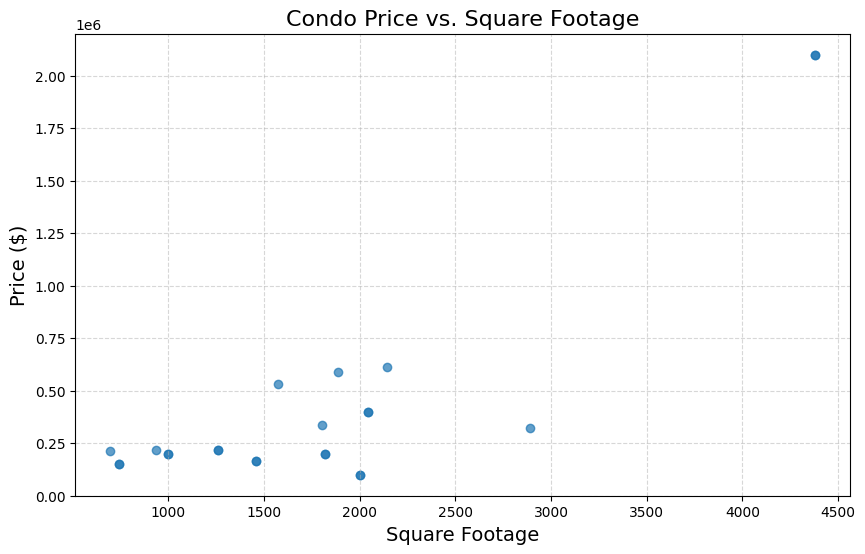

In [56]:
# Scatter plot: Price vs. Square Footage
plt.figure(figsize=(10, 6))
plt.scatter(df['Sqft'], df['Price'], alpha=0.7)
plt.title("Condo Price vs. Square Footage", fontsize=16)
plt.xlabel("Square Footage", fontsize=14)
plt.ylabel("Price ($)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

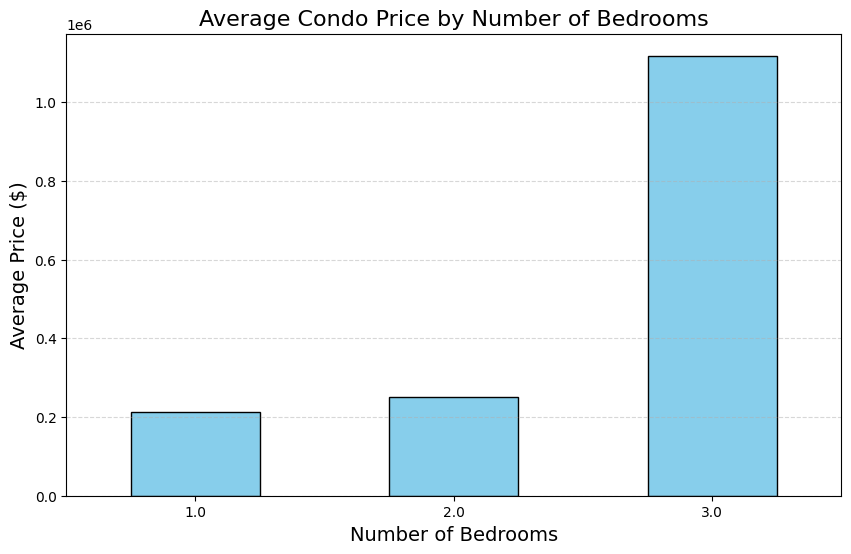

In [58]:
# Bar plot: Average Price by Number of Bedrooms
avg_price_by_bedrooms = df.groupby('Beds')['Price'].mean()
plt.figure(figsize=(10, 6))
avg_price_by_bedrooms.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Condo Price by Number of Bedrooms", fontsize=16)
plt.xlabel("Number of Bedrooms", fontsize=14)
plt.ylabel("Average Price ($)", fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

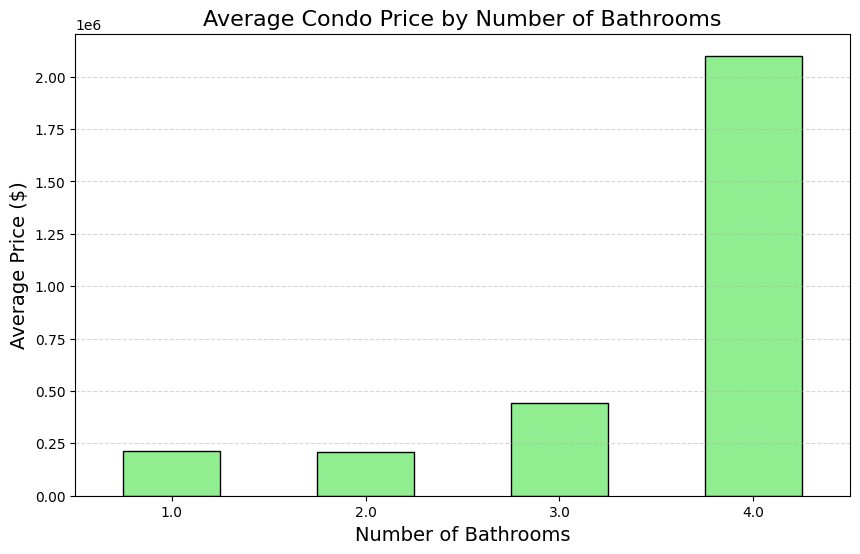

In [60]:
# Bar plot: Average Price by Number of Bathrooms
avg_price_by_bathrooms = df.groupby('Baths')['Price'].mean()
plt.figure(figsize=(10, 6))
avg_price_by_bathrooms.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Average Condo Price by Number of Bathrooms", fontsize=16)
plt.xlabel("Number of Bathrooms", fontsize=14)
plt.ylabel("Average Price ($)", fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

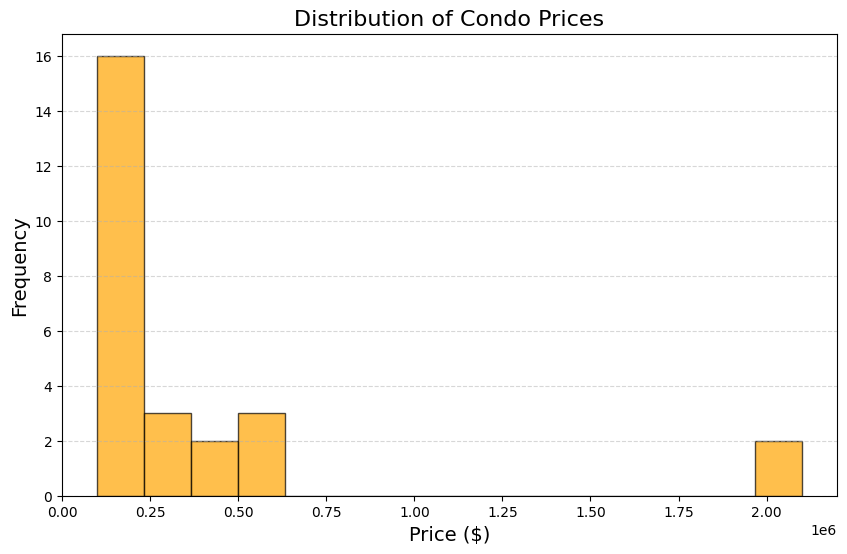

In [62]:
# Histogram: Distribution of Condo Prices
plt.figure(figsize=(10, 6))
plt.hist(df['Price'], bins=15, color='orange', edgecolor='black', alpha=0.7)
plt.title("Distribution of Condo Prices", fontsize=16)
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [64]:
# Split the Address column
address_split = df['Address'].str.extract(r'(?P<Number>\d+)\s(?P<Street>.+),\sCleveland, OH\s(?P<Zip_Code>\d{5})')

# Add the new columns to the dataframe
df['Number'] = address_split['Number']
df['Street'] = address_split['Street']
df['Zip_Code'] = address_split['Zip_Code']

# Drop the original Address column if no longer needed
df = df.drop(columns=['Address'])

# Save the updated dataframe
df.to_csv("zillow_cleveland_condos.csv", index=False)

In [66]:
df.head()

,Price,Beds,Baths,Sqft,Number,Street,Zip_Code
0,99900.0,2.0,2.0,2000.0,1383,East Blvd,44106
1,149900.0,1.0,1.0,742.0,750,Prospect Ave E APT 502,44115
2,205000.0,2.0,1.0,NaN,2043,Random Rd,44106
3,219900.0,1.0,2.0,1260.0,1951,W 26th St APT 414,44113
4,199000.0,2.0,2.0,1818.0,8205,Franklin Blvd APT 14,44102


In [70]:
# Extract the main part of the street address (excluding apartment/unit details)
df['Street'] = df['Street'].str.extract(r'^(.*?)(?:\s(?:APT|UNIT|#).*)?$')[0]

# Save the updated dataframe
df.to_csv("zillow_cleveland_condos.csv", index=False)

In [72]:
df.head()

,Price,Beds,Baths,Sqft,Number,Street,Zip_Code
0,99900.0,2.0,2.0,2000.0,1383,East Blvd,44106
1,149900.0,1.0,1.0,742.0,750,Prospect Ave E,44115
2,205000.0,2.0,1.0,NaN,2043,Random Rd,44106
3,219900.0,1.0,2.0,1260.0,1951,W 26th St,44113
4,199000.0,2.0,2.0,1818.0,8205,Franklin Blvd,44102


In [84]:
df['Sqft'].unique()

array([2000.,  742., 1260., 1818., 1000., 2044., 4378., 1456., 2890.,
       2141., 1800.,  696.,  936., 1574., 1885.])

In [82]:
df = df.dropna(subset=['Sqft'])

In [90]:
# Initialize geolocator
geolocator = Nominatim(user_agent="condo_map")

# Geocode function with error handling
def geocode(address):
    try:
        location = geolocator.geocode(f"{address}, Cleveland, OH")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        return None, None

# Apply geocoding to the street addresses
df['Lat'], df['Lon'] = zip(*df['Street'].apply(geocode))

# Drop rows where geocoding failed
df = df.dropna(subset=['Lat', 'Lon'])

# Initialize the map centered around Cleveland
m = folium.Map(location=[41.4993, -81.6944], zoom_start=12)

# Add markers to the map
for _, row in df.iterrows():
    popup_info = f"""
    <b>Price:</b> {row['Price']}<br>
    <b>Bedrooms:</b> {row['Beds']}<br>
    <b>Bathrooms:</b> {row['Baths']}<br>
    <b>Square Footage:</b> {row['Sqft']} sqft
    """
    folium.Marker(
        location=[row['Lat'], row['Lon']],
        popup=folium.Popup(popup_info, max_width=300),
        tooltip=row['Street'],
        icon=folium.Icon(color="blue", icon="home")
    ).add_to(m)

# Save the map to an HTML file
m.save("cleveland_condos_map.html")

# Display the map in Jupyter Notebook (if you're using one)
m

In [94]:
# Initialize geolocator
geolocator = Nominatim(user_agent="condo_map")

# Geocode function with error handling
def geocode(address):
    try:
        location = geolocator.geocode(f"{address}, Cleveland, OH")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        return None, None

# Apply geocoding to the street addresses (if not already geocoded)
if "Lat" not in df.columns or "Lon" not in df.columns:
    df['Lat'], df['Lon'] = zip(*df['Street'].apply(geocode))

# Drop rows where geocoding failed
df = df.dropna(subset=['Lat', 'Lon'])

# Convert price to numerical for color mapping
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

# Create a color scale based on price
price_colormap = cm.linear.YlOrRd_09.scale(df['Price'].min(), df['Price'].max())

# Initialize the map centered around Cleveland
m = folium.Map(location=[41.4993, -81.6944], zoom_start=12)

# Add markers with color-coded icons
for _, row in df.iterrows():
    popup_info = f"""
    <b>Price:</b> ${row['Price']:,}<br>
    <b>Bedrooms:</b> {row['Beds']}<br>
    <b>Bathrooms:</b> {row['Baths']}<br>
    <b>Square Footage:</b> {row['Sqft']} sqft
    """
    color = price_colormap(row['Price'])  # Get the color for the price
    folium.CircleMarker(
        location=[row['Lat'], row['Lon']],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_info, max_width=300),
        tooltip=row['Street']
    ).add_to(m)

# Add the color scale to the map
price_colormap.caption = "Condo Price ($)"
price_colormap.add_to(m)

# Save the map to an HTML file
m.save("cleveland_condos_price_map.html")

# Display the map in Jupyter Notebook
m


<>:23: SyntaxWarning: invalid escape sequence '\$'
<>:23: SyntaxWarning: invalid escape sequence '\$'
C:\Users\gayat\AppData\Local\Temp\ipykernel_22180\1639307158.py:23: SyntaxWarning: invalid escape sequence '\$'
  df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)


In [98]:
# Initialize geolocator
geolocator = Nominatim(user_agent="condo_map")

# Geocode function with error handling
def geocode(address):
    try:
        location = geolocator.geocode(f"{address}, Cleveland, OH")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        return None, None

# Apply geocoding to the street addresses (if not already geocoded)
if "Lat" not in df.columns or "Lon" not in df.columns:
    df['Lat'], df['Lon'] = zip(*df['Street'].apply(geocode))

# Drop rows where geocoding failed
df = df.dropna(subset=['Lat', 'Lon'])

# Convert price to numerical for binning
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

# Define price bins and colors
bins = [0, 150000, 300000, 500000, float('inf')]
colors = ['green', 'blue', 'orange', 'red']
labels = ['Low (<$150k)', 'Medium ($150k-$300k)', 'High ($300k-$500k)', 'Luxury (>$500k)']

# Categorize prices into bins
df['Price_Category'] = pd.cut(df['Price'], bins=bins, labels=labels)

# Initialize the map with a simplified background
m = folium.Map(location=[41.4993, -81.6944], zoom_start=12, tiles="CartoDB Positron")

# Add markers
for _, row in df.iterrows():
    price_category = row['Price_Category']
    color = colors[labels.index(price_category)]
    folium.CircleMarker(
        location=(row['Lat'], row['Lon']),
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Price: ${row['Price']:,.0f}<br>Street: {row['Street']}<br>Bedrooms: {row['Beds']}<br>Bathrooms: {row['Baths']}<br>Sqft: {row['Sqft']}"
    ).add_to(m)

# Save the map to an HTML file and display it
m.save("cleveland_condos_price_map.html")
m

<>:23: SyntaxWarning: invalid escape sequence '\$'
<>:23: SyntaxWarning: invalid escape sequence '\$'
C:\Users\gayat\AppData\Local\Temp\ipykernel_22180\2880008797.py:23: SyntaxWarning: invalid escape sequence '\$'
  df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)


,Street,Number of Listings,Average Price,Median Price,Minimum Price,Maximum Price
0,Catlin Ct,1,590000.0,590000.0,590000.0,590000.0
1,Clinton Ave,1,614900.0,614900.0,614900.0,614900.0
2,Detroit Ave,2,164900.0,164900.0,164900.0,164900.0
3,E 40th St,1,324500.0,324500.0,324500.0,324500.0
4,East Blvd,2,99900.0,99900.0,99900.0,99900.0
5,Euclid Ave,1,529900.0,529900.0,529900.0,529900.0
6,Franklin Blvd,2,199000.0,199000.0,199000.0,199000.0
7,Prospect Ave E,2,149900.0,149900.0,149900.0,149900.0
8,W 26th St,2,219900.0,219900.0,219900.0,219900.0
9,W 9th St,2,215700.0,215700.0,211500.0,219900.0


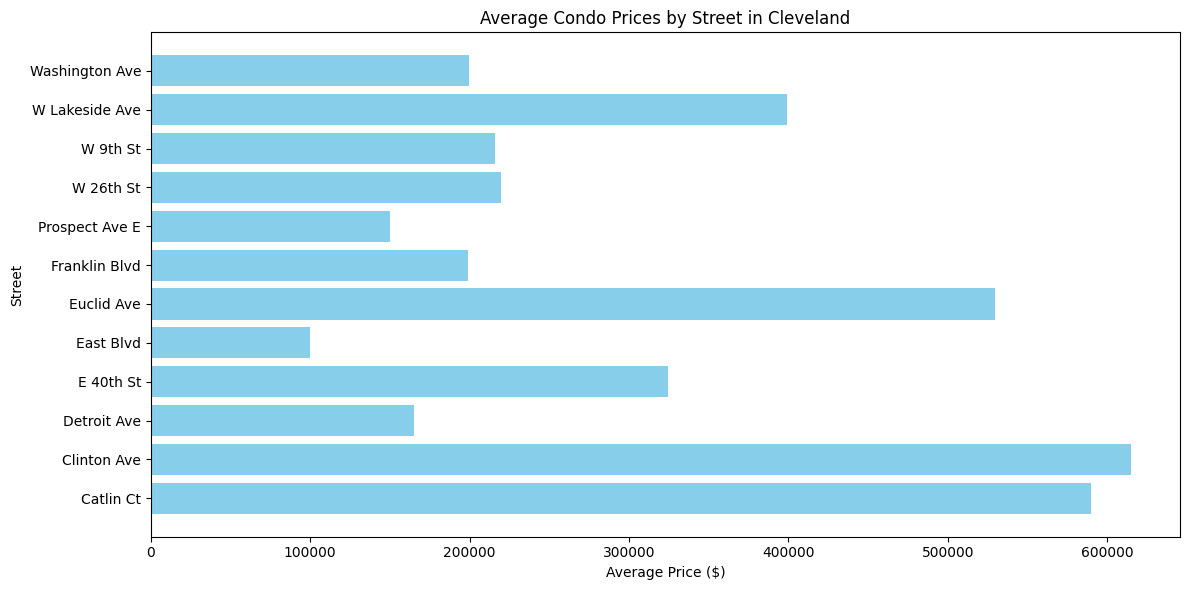

In [102]:
# Group by Street and calculate summary statistics
street_price_stats = df.groupby('Street')['Price'].agg(['count', 'mean', 'median', 'min', 'max']).reset_index()
street_price_stats.rename(columns={
    'count': 'Number of Listings',
    'mean': 'Average Price',
    'median': 'Median Price',
    'min': 'Minimum Price',
    'max': 'Maximum Price'
}, inplace=True)

# Display the results in the Jupyter Notebook
from IPython.display import display
display(street_price_stats)

# Plot the distribution of average prices across streets
plt.figure(figsize=(12, 6))
plt.barh(street_price_stats['Street'], street_price_stats['Average Price'], color='skyblue')
plt.xlabel('Average Price ($)')
plt.ylabel('Street')
plt.title('Average Condo Prices by Street in Cleveland')
plt.tight_layout()
plt.show()